# This notebook is for the Fair-Shapely experiment

In [21]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [23]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [24]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [49]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (5049, 18)
X_test shape: (2165, 18)


### 4. Train the original model

In [50]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6706697459584295


In [51]:
X_train['sex'].value_counts()

sex
1    4092
0     957
Name: count, dtype: int64

In [52]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [53]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.09679816663265228
original_train_DR: 0.09423558413982391


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 58
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 405
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改463个数据点, 使用new training set训练新模型


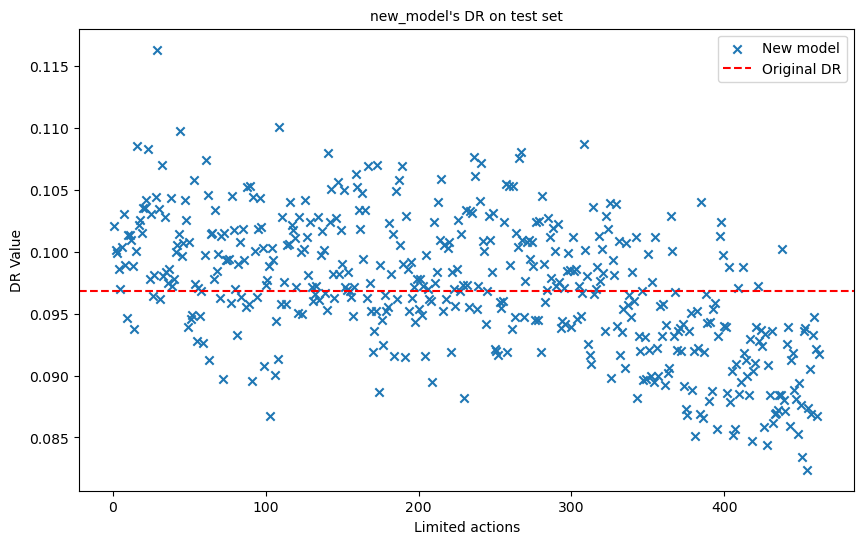

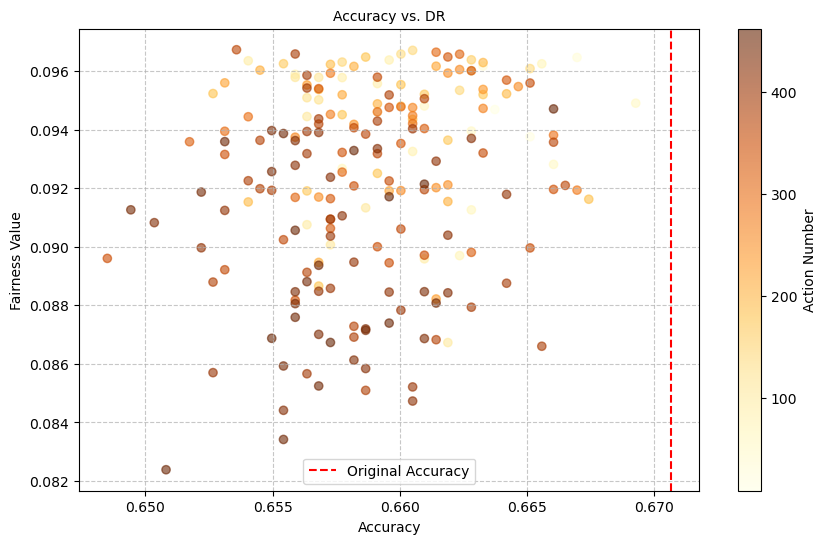

([0.10206252,
  0.10012291,
  0.09988749,
  0.098606355,
  0.097017854,
  0.100409895,
  0.10309224,
  0.09897446,
  0.09468372,
  0.10134889,
  0.10136541,
  0.100947514,
  0.09888145,
  0.093753815,
  0.10009332,
  0.1085317,
  0.10213954,
  0.102615476,
  0.10152272,
  0.1035545,
  0.10358267,
  0.10416943,
  0.10829966,
  0.0978195,
  0.103097364,
  0.096460864,
  0.09816214,
  0.104466036,
  0.116346315,
  0.10347824,
  0.09616699,
  0.107041076,
  0.09806575,
  0.10280997,
  0.09833554,
  0.09746219,
  0.09858705,
  0.10438344,
  0.09722241,
  0.09780874,
  0.09995515,
  0.10053679,
  0.101436146,
  0.10978785,
  0.09969381,
  0.10069327,
  0.10418911,
  0.102600686,
  0.09394814,
  0.100759305,
  0.09459468,
  0.09490002,
  0.10581028,
  0.097378574,
  0.0928104,
  0.0970697,
  0.094804004,
  0.09684658,
  0.092670344,
  0.09976713,
  0.10745651,
  0.10462216,
  0.091257766,
  0.101407744,
  0.101507485,
  0.09784832,
  0.103375286,
  0.0984645,
  0.09985663,
  0.096243896,
  0.

In [54]:
from src.experiments_approach4 import ExperimentNew4
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew4(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            original_Xtest_DR = original_test_DR,
                            original_Xtest_acc = accuracy,)
experiment.run_experiment()
